In [18]:
#  import libraries
import h5py
import os, sys
import zipfile
import numpy as np
from mpi4py import MPI
import matplotlib.pyplot as plt

# --- Configuration ---
sys.path.insert(0, '../../../config')
from _utility_imports import *

In [19]:
# Path to the ZIP file
# check if .zip file exists
if not os.path.exists("results.zip"):
    print("The file 'results.zip' does not exist.")
    sys.exit()
    
# zip_file_path = "results_noloc.zip"
zip_file_path = "results.zip"
output_folder = "results"

# Unzip the file
if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Create the output folder if it doesn't exist
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        zip_ref.extractall(output_folder)
    print(f"Extracted '{zip_file_path}' to '{output_folder}'")
else:
    print(f"The file '{zip_file_path}' does not exist.")


Extracted 'results.zip' to 'results'


Reading data from results/true-wrong-icepack.h5...
Dataset 'Lxy' extracted with shape (2,)
Dataset 'b_io' extracted with shape (2,)
Dataset 'nxy' extracted with shape (2,)
Dataset 'obs_index' extracted with shape (8,)
Dataset 'obs_max_time' extracted with shape (1,)
Dataset 'statevec_nurged' extracted with shape (1700, 201)
Dataset 'statevec_true' extracted with shape (1700, 201)
Dataset 't' extracted with shape (201,)
Dataset 'w' extracted with shape (1700, 8)
Data extraction complete.
At h_indx = 100 profile 
(8,)


Text(0.5, 1.0, 'middle profile at h_indx = 100')

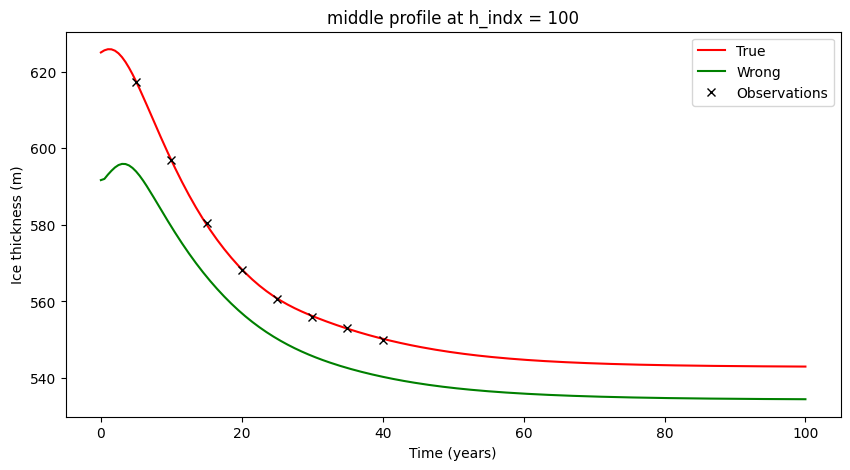

In [20]:
filter_type = "true-wrong"
file_path = f"results/{filter_type}-icepack.h5"
datasets_tw = extract_datasets_from_h5(file_path)
t=datasets_tw['t']
statevec_true = datasets_tw['statevec_true']
statevec_nurged = datasets_tw['statevec_nurged']
w = datasets_tw['w']
ind_m = datasets_tw['obs_index']
tm_m = datasets_tw['obs_max_time'][0]

nt = statevec_true.shape[1]; num_steps = nt-1
ndim = statevec_true.shape[0]
hdim = ndim//4 # [h,u,v,smb]

# plot the statevec_true and statevec_nurged
htrue = statevec_true[:hdim,:]
hnurge = statevec_nurged[:hdim,:]

# define profile flag
profile_flag = "middle" # begining, middle, end, random
# h_indx = 0 # first profile
# h_indx = htrue.shape[1]//2 # middle profile
# h_indx = htrue.shape[1]-1 # last profile
# h_indx = np.random.randint(htrue.shape[1])  # random profile
if profile_flag == "begining":
    h_indx = 0 # first profile
elif profile_flag == "middle":
    h_indx = htrue.shape[1]//2
elif profile_flag == "end":
    h_indx = htrue.shape[1]-1
elif profile_flag == "random":
    h_indx = np.random.randint(htrue.shape[1])

print(f"At h_indx = {h_indx} profile ")

h_true = htrue[h_indx,:]
h_nurged = hnurge[h_indx,:]

plt.figure(figsize=(10,5))
plt.plot(t,h_true,'r',label='True')
plt.plot(t,h_nurged,'g',label='Wrong')
obs = w[h_indx,:]; print(obs.shape)
plt.plot(t[ind_m],obs,'kx',label="Observations")
plt.xlabel('Time (years)')
plt.ylabel('Ice thickness (m)')
plt.legend()
plt.title(f"{profile_flag} profile at h_indx = {h_indx}")

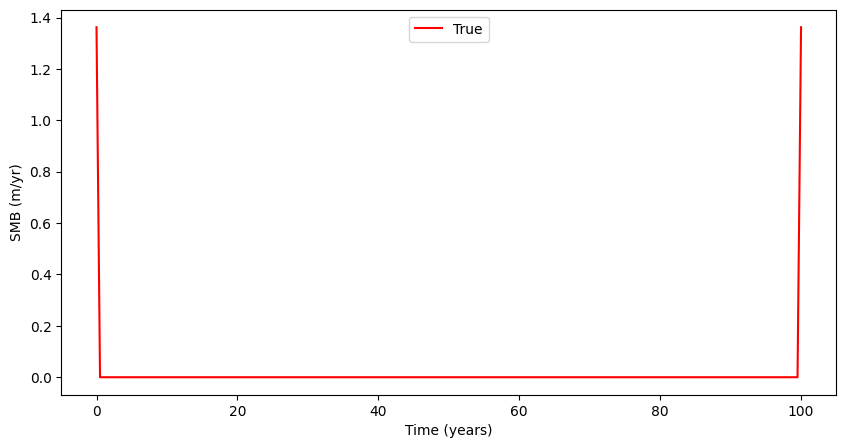

In [21]:
# extract smb
smbtrue = statevec_true[3*hdim:,:]

# plot the smbtrue
plt.figure(figsize=(10,5))
plt.plot(t,smbtrue[h_indx,:],'r',label='True')
plt.xlabel('Time (years)')
plt.ylabel('SMB (m/yr)')
plt.legend()

In [22]:
filter_type = "EnKF"
file_path = f"results/{filter_type}-icepack.h5"
datasets = extract_datasets_from_h5(file_path)
statevec_ens_full = datasets["statevec_ens_full"]
statevec_ens_mean = datasets["statevec_ens_mean"] 
statevec_bg       = datasets["statevec_bg"]


Reading data from results/EnKF-icepack.h5...
Dataset 'statevec_bg' extracted with shape (1700, 201)
Dataset 'statevec_ens_full' extracted with shape (1700, 30, 201)
Dataset 'statevec_ens_mean' extracted with shape (1700, 201)
Data extraction complete.


In [23]:
from firedrake import *
import firedrake

Lx, Ly = datasets_tw["Lxy"][0], datasets_tw["Lxy"][1]
nx, ny = datasets_tw["nxy"][0], datasets_tw["nxy"][1]

mesh = firedrake.RectangleMesh(nx, ny, Lx, Ly)
Q = firedrake.FunctionSpace(mesh, "CG", 2)
V = firedrake.VectorFunctionSpace(mesh, "CG", 2)
x, y = firedrake.SpatialCoordinate(mesh)
b_in, b_out = datasets_tw["b_io"][0], datasets_tw["b_io"][1]
b = firedrake.interpolate(b_in - (b_in - b_out) * x / Lx, Q)

# form a rectangular mesh and get x, y coordinates
x, y = np.meshgrid(np.linspace(0, Lx, nx), np.linspace(0, Ly, ny))
# x

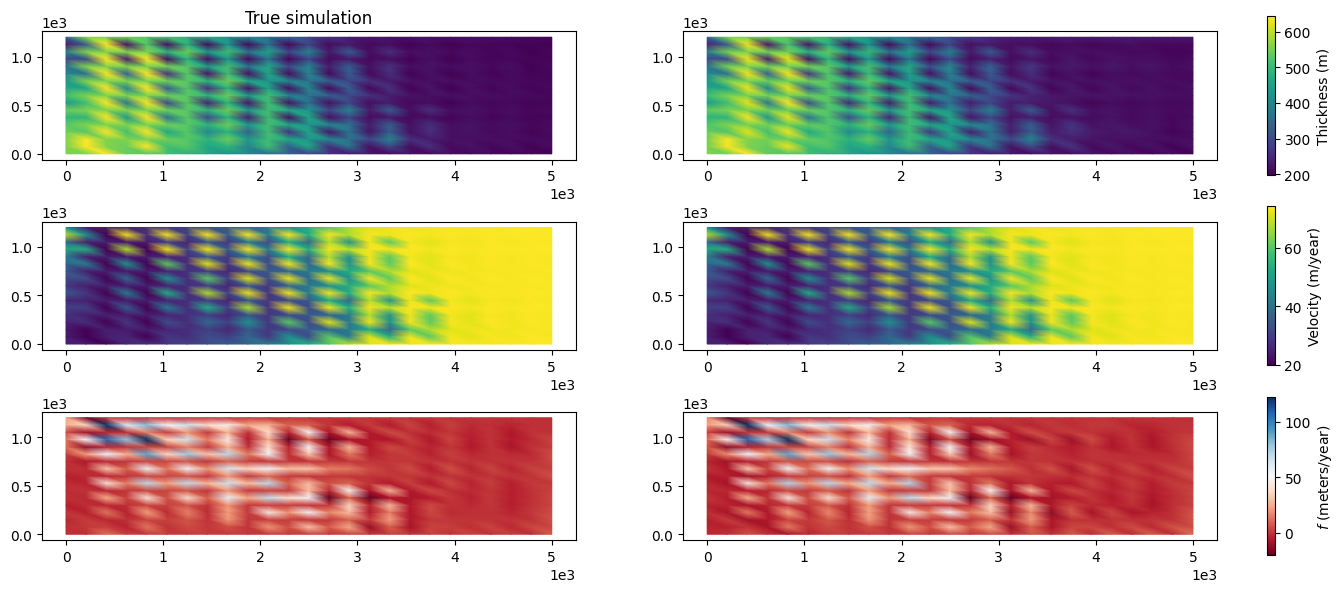

In [24]:
from firedrake import div
import copy
import icepack
import icepack.plot
fig, axes = icepack.plot.subplots(3,2, figsize=(16,7))
step = nt-1
hhtrue = firedrake.Function(Q)
uutrue = firedrake.Function(V)
hhtrue.dat.data[:] = copy.deepcopy(statevec_true[:hdim,step])
colors = firedrake.tripcolor(hhtrue, axes=axes[0][0])
fig.colorbar(colors, ax=axes[0], fraction=0.012, pad=0.04, label="Thickness (m)")
axes[0][0].set_title("True simulation")

# ploting the velocity field
uutrue.dat.data[:,0] = copy.deepcopy(statevec_true[hdim:2*hdim,step])
uutrue.dat.data[:,1] = copy.deepcopy(statevec_true[2*hdim:3*hdim,step])
colors = firedrake.tripcolor(uutrue, axes=axes[1][0])
fig.colorbar(colors, ax=axes[1], fraction=0.012, pad=0.04, label="Velocity (m/year)")

# ploting the basal shear stress
f = firedrake.interpolate(div(hhtrue*uutrue), Q)
colors = firedrake.tripcolor(f, axes=axes[2][0], cmap="RdBu")
fig.colorbar(colors, ax=axes[2], fraction=0.012, pad=0.04, label=r"$f$ (meters/year)")

# axes[0][1].set_title("EnKF simulation")
# axes[0][1].set_title(f"{filter_type} simulation: RMSE = {rmse:.2f}")
hhenkf = firedrake.Function(Q)
uuenkf = firedrake.Function(V)
hhenkf.dat.data[:] = copy.deepcopy(statevec_ens_mean[:hdim,step])
colors = firedrake.tripcolor(hhenkf, axes=axes[0][1])
# fig.colorbar(colors, ax=axes[0], fraction=0.012, pad=0.04, label="Thickness (m)")


# ploting the velocity field
uuenkf.dat.data[:,0] = copy.deepcopy(statevec_ens_mean[hdim:2*hdim,step])
uuenkf.dat.data[:,1] = copy.deepcopy(statevec_ens_mean[2*hdim:3*hdim,step])
colors = firedrake.tripcolor(uuenkf, axes=axes[1][1])


# ploting the basal shear stress
f = firedrake.interpolate(div(hhenkf*uuenkf), Q)
colors = firedrake.tripcolor(f, axes=axes[2][1], cmap="RdBu")

Text(0, 0.5, 'thickness (m)')

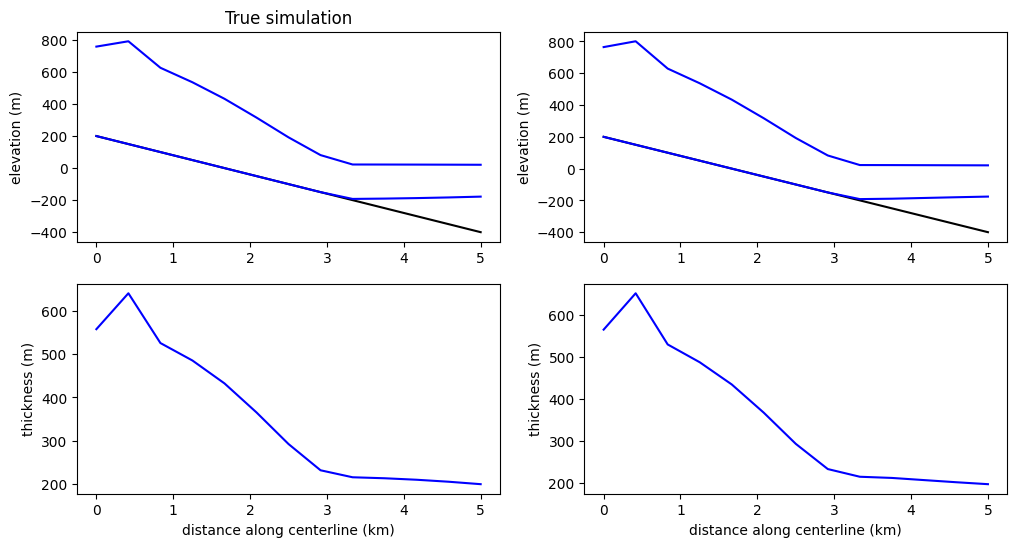

In [25]:
# we can draw some transects through the domain to see what the surface, bed, and ice base elevation look like

xs = np.array([(Lx * k /nx, 0) for k in range(nx + 1)])
s = icepack.compute_surface(thickness = hhtrue, bed = b)

ss = np.array(s.at(xs, tolerance=1e-10))
bs = np.array(b.at(xs, tolerance=1e-10))
hs = np.array(hhtrue.at(xs, tolerance=1e-10))

fig, axes = plt.subplots(2,2, figsize=(12, 6))
axes[0,0].plot(xs[:, 0] / 1e3, bs, color="black")
axes[0,0].plot(xs[:, 0] / 1e3, ss - hs, color="blue")
axes[0,0].plot(xs[:, 0] / 1e3, ss, color="blue")
# axes[0,0].set_xlabel("distance along centerline (km)")
axes[0,0].set_ylabel("elevation (m)")
axes[0,0].set_title("True simulation")

axes[1,0].plot(xs[:, 0] / 1e3, hs, color="blue")
axes[1,0].set_xlabel("distance along centerline (km)")
axes[1,0].set_ylabel("thickness (m)")


s = icepack.compute_surface(thickness = hhenkf, bed = b)

ss = np.array(s.at(xs, tolerance=1e-10))
bs = np.array(b.at(xs, tolerance=1e-10))
hs = np.array(hhenkf.at(xs, tolerance=1e-10))

axes[0,1].plot(xs[:, 0] / 1e3, bs, color="black")
axes[0,1].plot(xs[:, 0] / 1e3, ss - hs, color="blue")
axes[0,1].plot(xs[:, 0] / 1e3, ss, color="blue")
# axes[0,1].set_xlabel("distance along centerline (km)")
axes[0,1].set_ylabel("elevation (m)")
# axes[0,1].set_title("DEnKF simulation")
# axes[0,1].set_title(f"{filter_type} simulation: RMSE = {rmse:.2f}")

axes[1,1].plot(xs[:, 0] / 1e3, hs, color="blue")
axes[1,1].set_xlabel("distance along centerline (km)")
axes[1,1].set_ylabel("thickness (m)")

Text(0.5, 1.0, 'middle profile at u_indx = 525 and v_indx = 950')

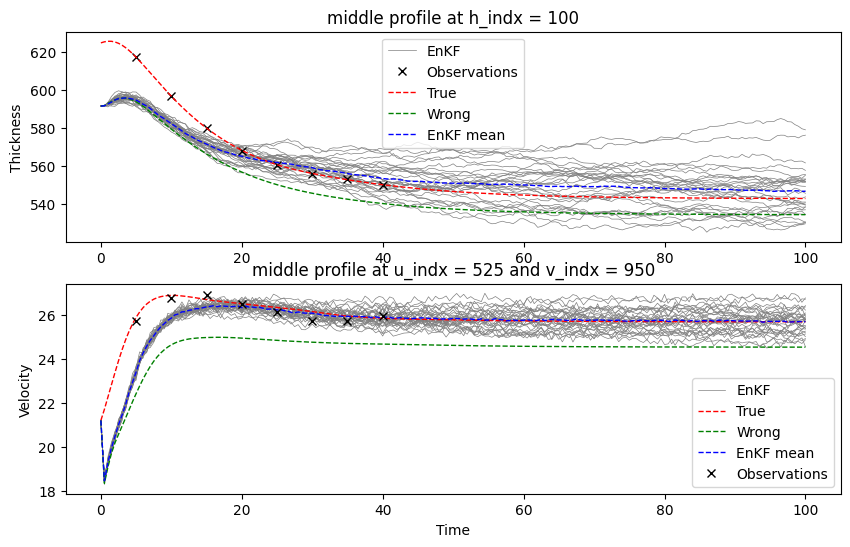

In [26]:
fig, ax = plt.subplots(2,1, figsize=(10, 6))

# h_obs = utils_funs.Obs_fun(hu_obs[:hdim,:])
obs_h = w[h_indx,:]


# plot the h middle profile
# h_indx = hens.shape[1]//2
hens = statevec_ens_mean[:hdim,:]
h_true = htrue[h_indx,:]
h_nurged = hnurge[h_indx,:]
h_ens_mean = hens[h_indx,:]
h_ens_mem  = statevec_ens_full[h_indx,:,:].T
# h_ob = h_ob[-1,:]
Nens = statevec_ens_full.shape[1]
for ens in range(Nens):
    ax[0].plot(t,h_ens_mem[:,ens], lw=0.5, color='gray',label=f"{filter_type}" if ens == 0 else "")

# ax[0].plot(ts,h_ens_mem[:,:], lw=0.5, color='k',label="DEnKF ens")
ax[0].plot(t[ind_m],obs_h,'kx',label="Observations")

ax[0].plot(t,h_true,'--r',label='True',linewidth=1)
ax[0].plot(t,h_nurged,'--g',label='Wrong',linewidth=1)
ax[0].plot(t,h_ens_mean,'--b',label=f"{filter_type} mean",linewidth=1)
# ax[0].plot(t[ind_m],hu_ob[1,:],'kx',label='Observations')
ax[0].legend()
# ax[0].set_ylim([350, 500])
# ax[0].set_xlim([1, 250])
# ax[0].set_xlabel('Time')
ax[0].set_ylabel('Thickness')
ax[0].set_title(f"{profile_flag} profile at h_indx = {h_indx}")

# plot the u middle profile
# u_ob = utils_funs.Obs_fun(hu_obs[hdim:2*hdim,:])
# v_ob = utils_funs.Obs_fun(hu_obs[2*hdim:,:])
# uobs = np.sqrt(u_ob**2 + v_ob**2)
u_indx = hdim + h_indx
v_indx = 2*hdim + h_indx
obs_u = w[u_indx,:]
obs_v = w[v_indx,:]
uobs = np.sqrt(obs_u**2 + obs_v**2)
u_true = statevec_true[u_indx,:]
v_true = statevec_true[v_indx,:]
utrue = np.sqrt(u_true**2 + v_true**2)
u_nurge = statevec_nurged[u_indx,:]
v_nurge = statevec_nurged[v_indx,:]
unurge = np.sqrt(u_nurge**2 + v_nurge**2)
u_ens_mean = statevec_ens_mean[u_indx,:]
v_ens_mean = statevec_ens_mean[v_indx,:]
uens_mean = np.sqrt(u_ens_mean**2 + v_ens_mean**2)
u_ens_mem  = statevec_ens_full[u_indx,:,:].T
v_ens_mem  = statevec_ens_full[v_indx,:,:].T
uens_mem = np.sqrt(u_ens_mem**2 + v_ens_mem**2)
for ens in range(Nens):
    ax[1].plot(t,uens_mem[:,ens], lw=0.5, color='gray',label=f"{filter_type}" if ens == 0 else "")

ax[1].plot(t,utrue,'--r',label='True',linewidth=1)
ax[1].plot(t,unurge,'--g',label='Wrong',linewidth=1)
ax[1].plot(t,uens_mean,'--b',label=f"{filter_type} mean",linewidth=1)
ax[1].plot(t[ind_m],uobs,'kx',label='Observations')
ax[1].legend()
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Velocity')
ax[1].set_title(f"{profile_flag} profile at u_indx = {u_indx} and v_indx = {v_indx}")


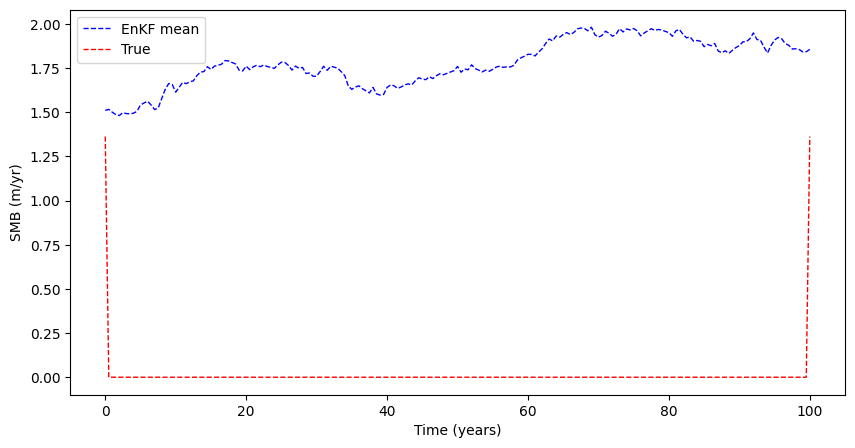

In [ ]:
# plot the smb middle profile
smbtrue = statevec_true[3*hdim:,:]
# smb_indx = 3*hdim + h_indx
# smbs_true = smbtrue[smb_indx,:]
smbs_ens_mean = statevec_ens_mean[3*hdim:,:]
smb_nurged = statevec_nurged[3*hdim:,:]
# smbs_ens_mem  = statevec_ens_full[smb_indx,:,:].T
# for ens in range(Nens):
#     ax[0].plot(t,smbs_ens_mem[:,ens], lw=0.5, color='gray',label=f"{filter_type}" if ens == 0 else "")

plt.figure(figsize=(10,5))
plt.plot(t,smbs_ens_mean[h_indx,:],'--b',label=f"{filter_type} mean",linewidth=1)
plt.plot(t,smbtrue[h_indx,:],'--r',label='True',linewidth=1)
plt.plot(t,smb_nurged[h_indx,:],'--g',label='Wrong',linewidth=1)
plt.xlabel('Time (years)')
plt.ylabel('SMB (m/yr)')
plt.legend()


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

def gaspari_cohn(r):
    """
    Compute the Gaspari-Cohn localization function.
    
    Parameters:
    r (numpy array): Normalized distance (d / r0), where d is the Euclidean distance 
                     and r0 is the localization radius.
    
    Returns:
    numpy array: Localization weights corresponding to r.
    """
    gc = np.zeros_like(r)  # Initialize localization weights

    # Case 0 <= r < 1
    mask1 = (r >= 0) & (r < 1)
    gc[mask1] = (((-0.25 * r[mask1] + 0.5) * r[mask1] + 0.625) * r[mask1] - 5.0 / 3.0) * r[mask1]**2 + 1

    # Case 1 <= r < 2
    mask2 = (r >= 1) & (r < 2)
    gc[mask2] = ((((1.0 / 12.0 * r[mask2] - 0.5) * r[mask2] + 0.625) * r[mask2] + 5.0 / 3.0) * r[mask2] - 5.0) * r[mask2] + 4.0 - 2.0 / (3.0 * np.where(r[mask2] == 0, 1e-10, r[mask2]))

    # Case r >= 2 (default to 0)
    return gc


def create_tapering_matrix(grid_x, grid_y, localization_radius):
    """
    Create a tapering matrix using the Gaspari-Cohn localization function.

    Parameters:
    grid_x (numpy array): X-coordinates of grid points (1D array).
    grid_y (numpy array): Y-coordinates of grid points (1D array).
    localization_radius (float): Cutoff radius beyond which correlations are zero.

    Returns:
    numpy array: Tapering matrix (NxN), where N = number of grid points.
    """
    # Stack grid points into (N, 2) array where N is the number of points
    grid_points = np.column_stack((grid_x.ravel(), grid_y.ravel()))

    # Compute pairwise Euclidean distances
    distance_matrix = cdist(grid_points, grid_points, metric='euclidean')

    # Normalize distances by localization radius
    normalized_distances = distance_matrix / localization_radius

    # Apply the Gaspari-Cohn function to get tapering weights
    tapering_matrix = gaspari_cohn(normalized_distances)

    return tapering_matrix


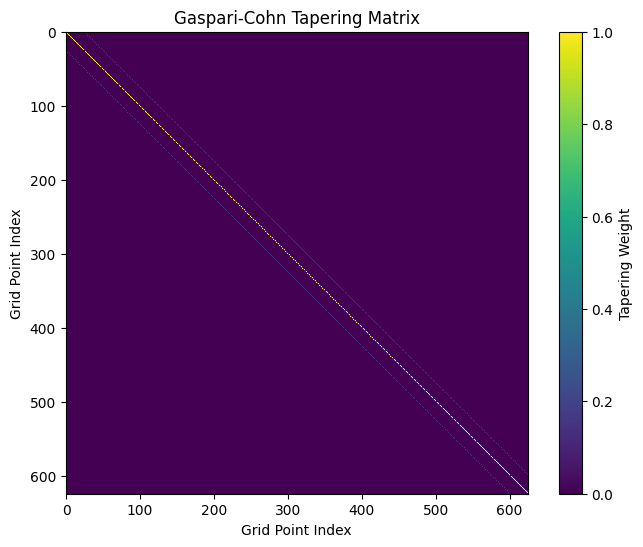

In [29]:
# Create a 2D grid (5x5 points)
x = np.linspace(0, 40, 25)  # X-coordinates
y = np.linspace(0, 40, 25)  # Y-coordinates
grid_x, grid_y = np.meshgrid(x, y)  # Create mesh grid

# Set localization radius
r0 = 1.5  # Influence radius for tapering

# Compute the tapering matrix
tapering_matrix = create_tapering_matrix(grid_x, grid_y, r0)

# Plot the tapering matrix
plt.figure(figsize=(8, 6))
plt.imshow(tapering_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Tapering Weight')
plt.title('Gaspari-Cohn Tapering Matrix')
plt.xlabel('Grid Point Index')
plt.ylabel('Grid Point Index')
plt.show()


In [30]:
def compute_adaptive_localization_radius(ensemble, grid_x, grid_y, base_radius=2.0, method='variance'):
    """
    Compute an adaptive localization radius for each grid point.

    Parameters:
    ensemble (numpy array): Ensemble state matrix (N_grid x N_ens).
    grid_x (numpy array): X-coordinates of grid points (1D array).
    grid_y (numpy array): Y-coordinates of grid points (1D array).
    base_radius (float): Default radius before adaptation.
    method (str): 'variance', 'observation_density', or 'correlation'.

    Returns:
    numpy array: Adaptive localization radius for each grid point.
    """
    num_points, Nens = ensemble.shape  # Get grid size and ensemble size
    adaptive_radius = np.full(num_points, base_radius)  # Default radius

    if method == 'variance':
        # Compute ensemble variance at each grid point
        ensemble_variance = np.var(ensemble, axis=1)

        # Normalize variance (relative to max spread)
        normalized_variance = ensemble_variance / np.max(ensemble_variance)

        # Scale localization radius based on variance
        adaptive_radius *= (1 + normalized_variance)

    elif method == 'observation_density':
        # Compute observation density (using a Gaussian kernel approach)
        grid_points = np.column_stack((grid_x.ravel(), grid_y.ravel()))
        obs_density = np.sum(np.exp(-cdist(grid_points, grid_points, 'euclidean')**2 / base_radius**2), axis=1)

        # Normalize observation density
        normalized_density = obs_density / np.max(obs_density)

        # Decrease localization radius in high-density regions
        adaptive_radius *= (1 - normalized_density)

    elif method == 'correlation':
        # Compute correlation matrix from the ensemble
        correlation_matrix = np.corrcoef(ensemble, rowvar=True)

        # Set radius where correlation drops below 1/sqrt(Nens-1)
        threshold = 1 / np.sqrt(Nens - 1)
        for i in range(num_points):
            below_threshold = np.where(correlation_matrix[i, :] < threshold)[0]
            if below_threshold.size > 0:
                adaptive_radius[i] = base_radius * np.min(below_threshold) / num_points  # Scale adaptively

    else:
        raise ValueError("Invalid method. Choose 'variance', 'observation_density', or 'correlation'.")

    return adaptive_radius


In [31]:
# Generate a synthetic ensemble (100 grid points, 10 ensemble members)
N_grid = 1000
N_ens = 30
ensemble = np.random.rand(N_grid, N_ens)

# Create synthetic grid coordinates (randomized for this example)
grid_x = np.linspace(0, 10, N_grid)
grid_y = np.linspace(0, 10, N_grid)

# Compute adaptive localization radius using variance-based adaptation
adaptive_radius = compute_adaptive_localization_radius(ensemble, grid_x, grid_y, base_radius=2.0, method='variance')

# Print sample of computed localization radii
print("Sample Adaptive Localization Radii:", adaptive_radius[:10])


Sample Adaptive Localization Radii: [3.10719523 3.53300888 2.8872869  3.02244975 3.25430256 3.81406695
 3.17680597 3.23621943 2.97528202 3.60823666]


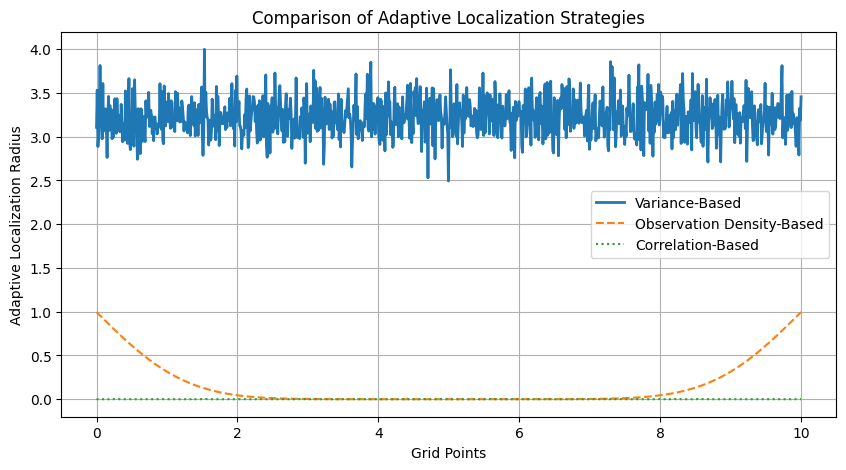

In [32]:
import matplotlib.pyplot as plt

# Compute localization radius with different methods
radius_variance = compute_adaptive_localization_radius(ensemble, grid_x, grid_y, method='variance')
radius_obs_density = compute_adaptive_localization_radius(ensemble, grid_x, grid_y, method='observation_density')
radius_correlation = compute_adaptive_localization_radius(ensemble, grid_x, grid_y, method='correlation')

# Plot adaptive localization radii
plt.figure(figsize=(10, 5))
plt.plot(grid_x, radius_variance, label='Variance-Based', linewidth=2)
plt.plot(grid_x, radius_obs_density, label='Observation Density-Based', linestyle='--')
plt.plot(grid_x, radius_correlation, label='Correlation-Based', linestyle='dotted')
plt.xlabel('Grid Points')
plt.ylabel('Adaptive Localization Radius')
plt.title('Comparison of Adaptive Localization Strategies')
plt.legend()
plt.grid()
plt.show()
